In [1]:
import pathlib as pl

import glob
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_palette(sns.color_palette("colorblind"))

import itertools, warnings

from collections import Counter, defaultdict
from typing import List, Dict, Tuple

In [2]:
# TODO:
# - Clean this notebook
# - Add fairness_auc as a metric
# - Replace NLTK's tokenization with Spacy tokenization.

In [3]:
def canonic_model_name(model_name: str) -> str:
    """Obtain the model's canonic name (excluding company)."""
    if "EleutherAI__" in model_name:
        model_name = model_name.replace("EleutherAI__", "")
    elif "facebook__" in model_name:
        model_name = model_name.replace("facebook__", "")
    elif "llama" in model_name:
        ix = model_name.index("llama")
        model_name = model_name[ix:].replace("__hf_models__", "-")
    elif "mosaicml__" in model_name:
        model_name = model_name.replace("mosaicml__", "")
        
    if "deduped" in model_name:
        model_name = model_name.replace("-deduped", " (D)")
    return model_name.rpartition("__step")[0]


def get_model_size(canonic_name: str) -> float:
    """Obtain the model size from the model's name"""
    import re 
    val = re.search(r"(\d+(\.\d+)?)(b|B|m|M)", canonic_name)[0]
    const = 1_000 if val[-1] in ("b", "B") else 1        
    return float(val[:-1]) * const


def get_model_step(name: str) -> int:
    model_name = name.rpartition("__step")[-1]
    return int(model_name)


def get_model_intervention(name: str) -> str:
    if "intervention" in name:
        return "intervention"
    elif "deduped" in name:
        return "deduped"
    else:
        return "other"

In this notebook, we focus on the evaluation of the benchmarks at a sentence-level using the proposed fairness metric (both threshold based and AUC). We show the impact of different pretraining interventions in the behavior of Pythia language models. 

To do this, we compare three models (1) the original Pythia models, trained in PILE's duplicate version, (2) the same model trained on the deduplicated version, and (3) models whose training procedure incorporated the gender-swapping bias mitigation procedure.

In [4]:
BASE_DIR = ".."

# list all the score files per dataset
DATASET_2_FILEPATHS = {
    "Ours-5": glob.glob(f"../results-words5/intervention-results/*__scores__*.csv"),
    # Baselines below ----
    "Winobias": glob.glob(f"../results-baselines/intervention-results/*Winobias*__scores__*.csv"),
    "Winogender": glob.glob(f"../results-baselines/intervention-results/*Winogender*__scores__*.csv"),
    # "StereoSet": glob.glob(f"../results-baselines/intervention-results/*StereoSet*__scores__*.csv"),
    # We define this ordering so that we can automatically obtain the same coloring scheme as
    # the one used for word analysis
    "Ours-10": glob.glob(f"../results-words10/intervention-results/*__scores__*.csv"),
    "Ours-20": glob.glob(f"../results-words20/intervention-results/*__scores__*.csv"),
}
DATASET_2_FILEPATHS = {k: sorted(v) for k, v in DATASET_2_FILEPATHS.items()}
DATASET_NAMES = list(DATASET_2_FILEPATHS.keys())
print(DATASET_NAMES)

for name, files in DATASET_2_FILEPATHS.items():
    print(name, len(files), "files")

['Ours-5', 'Winobias', 'Winogender', 'Ours-10', 'Ours-20']
Ours-5 13 files
Winobias 26 files
Winogender 13 files
Ours-10 13 files
Ours-20 13 files


In [5]:
# Read the files paths
# --------------------------------
# When reading the filepaths, there are a few things we'd like to do
# 1. record which model it belongs to
def get_model_name(filepath: str, suffix="__scores__") -> str:
    """This method assumes that the model name follows a given suffix"""
    model_name = filepath.rpartition(suffix)[-1]
    # remove the extension
    model_name = model_name.rpartition(".")[0]
    if model_name.startswith("__extra__ucinlp1__"):
        # print(model_name)
        model_name = model_name.replace("__extra__ucinlp1__","").replace("__hf_models_", "")
        # print(model_name)
    return model_name
    
# -----------------------------------------------------------------
# For datasets containing multiple splits, separated across files
# it will be the case, that we will have multiple model names for
# the same dataset name.
# -----------------------------------------------------------------
# We will send a warning and merge the two files. Assuming
# they are part of the same dataset. Please make sure that
# the listed files are not redundant and that indeed can be
# merged!
# -----------------------------------------------------------------
DATASET_2_FILES = defaultdict(list)
for name, filepaths in DATASET_2_FILEPATHS.items():
    models = {fp: get_model_name(fp) for fp in filepaths}
    models_2_fp, models_2_data = defaultdict(list), defaultdict(list)
    
    for fp, model_name in models.items():
        models_2_data[model_name].append(pd.read_csv(fp, index_col=0))
        models_2_fp[model_name].append(fp)
    
    for model_name, dfs in models_2_data.items():
        if len(dfs) > 1:
            # print()
            # print(f"Dataset '{name}' contains more than one filepath per model. {models_2_fp[model_name]}")
            dfs_lens = [len(d) for d in dfs]
            dfs = pd.concat(dfs).reset_index(drop=True)
            assert len(dfs) == sum(dfs_lens), "Invalid result when merging dataframes"
        else:
            dfs = dfs[0]
                
        dfs["dataset"] = name
        dfs["is_deduped"] = model_name.endswith("deduped")
        dfs["__model"] = dfs["model"].apply(lambda x: x.replace("__extra__ucinlp1__", "").replace("__hf_models_", ""))
        dfs["model"] = dfs["__model"].apply(canonic_model_name)
        dfs["model_basename"] = dfs["model"].apply(lambda x: x.replace(" (D)", ""))

        dfs["__model_size"] = dfs["model"].apply(get_model_size)
        dfs["model_step"] = dfs["__model"].apply(get_model_step)
        dfs["model_intervention"] = dfs["__model"].apply(get_model_intervention)
        
        DATASET_2_FILES[name].append(dfs)

        
DATASET_2_FILES = {k: pd.concat(v).reset_index(drop=True) for k, v in DATASET_2_FILES.items()}

# comment section below to obtain results w/o likely/unliley
# filter the results by the "natural examples"
for dataset in DATASET_2_FILES:
    df = DATASET_2_FILES[dataset]
    if "is_natural" in df.columns:
        DATASET_2_FILES[dataset] = df[df["is_natural"]].reset_index(drop=True)
        print(len(df), len(DATASET_2_FILES[dataset]))
    
# loaded the model scores
NUM_EVAL_MODELS = []
for dataset,df  in DATASET_2_FILES.items():
    print(dataset, df["__model"].nunique())
    NUM_EVAL_MODELS.append(df["__model"].nunique())
assert len(set(NUM_EVAL_MODELS)) ==1, f"Found various model sizes: {NUM_EVAL_MODELS}"
NUM_EVAL_MODELS = NUM_EVAL_MODELS[0]
print("="*30, "\n", "Evaluating", NUM_EVAL_MODELS, "models!")
# collect the templates
DATANAME_TO_TEMPLATES = {k: v["template"].values.tolist() for k, v in DATASET_2_FILES.items()}

# list the names of the datasets in our analysis
DATANAMES = list(DATANAME_TO_TEMPLATES.keys())
print("Considering the following for the analysis", DATANAMES)

64402 57265
64259 61620
64285 62907
Ours-5 13
Winobias 13
Winogender 13
Ours-10 13
Ours-20 13
 Evaluating 13 models!
Considering the following for the analysis ['Ours-5', 'Winobias', 'Winogender', 'Ours-10', 'Ours-20']


### Preprocessing

Let us map each dataset into a canonic representation. We'll transform them according to the following rules:

1. Remove pronoun placeholder, since we do not want it to be mapped to any PMI word;
2. Lowercase the templates
3. Remove stopwords and punctuation

In [6]:
PRONOUNS = ["she", "her", "hers", "he", "his", "him", "himself", "herself"]

In [7]:
import nltk 
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string, re
nltk.download('stopwords')

NLTK_STOPWORDS = set(stopwords.words('english'))
# We know that some sentences have some other references to other entities,
# let's keep some pronouns
print(len(NLTK_STOPWORDS))
NLTK_STOPWORDS -= set(PRONOUNS)
print(len(NLTK_STOPWORDS))

PUNCT = string.punctuation

179
171


[nltk_data] Downloading package stopwords to /home/cbelem/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
DATANAME_TO_TEMPLATES_CANONIC: Dict[str, List[str]] = {k: v.copy() for k, v in DATANAME_TO_TEMPLATES.items()}

for dataset in DATANAME_TO_TEMPLATES_CANONIC.keys():
    # Lower case
    templates = [t.lower() for t in DATANAME_TO_TEMPLATES_CANONIC[dataset]]
    
    # Remove pronouns first
    templates = [t.replace("{pronoun2}self", "") for t in templates]
    templates = [re.sub(r"\{pronoun([0-2]{1})?\}", "", t) for t in templates]
    
    # Remove stopwords and punct
    templates = [[w for w in word_tokenize(t) if w not in PUNCT and w not in NLTK_STOPWORDS] for t in templates]
    
    DATANAME_TO_TEMPLATES_CANONIC[dataset] = templates

### USING SPACY

In [9]:
FREQ_WORDS = pd.read_csv("./pmi_file_w_counts.csv", index_col=0)
FREQ_WORDS["log_freq"] = np.log(FREQ_WORDS["freq"])
FREQ_WORDS["log_freq"].min(), FREQ_WORDS["log_freq"].max()

(-17.953214083404973, -2.719597143373469)

In [10]:
from utils import GROUP_PAIRED_WORDLIST 

def get_pmi_diff(df: pd.DataFrame, col1: str, col2: str, clip: int=None, missing_val: float=0, prefix_col: str="pmi__") -> pd.Series:
    """Obtains the PMI difference between columns col1 and col2. 
    
    Parameters
    ----------
    df: pandas.DataFrame
    
    col1: str
        The female word to use for computing the PMI. Should be one of the
        available suffixes in the provided dataframe's columns.
    
    col2: str
        The male word to use for computing the PMI. Should be one of the
        available suffixes in the provided dataframe's columns.
        
    clip: int, optional
        Positive integer, specifies the cap. If not specified, the pmi
        difference is only computed for words that co-occur with both
        (col1, col2). If specified, we will fill the PMI value with 0
        (ideally it would be a very negative number). You can tweak
        this value using 'missing_val'.
        
    prefix_col: str
        The prefix anteceding the col1 and col2 in the provided dataframe.
        In our files, we prefixes all columns with gendered lexicons using
        the "pmi__" prefix.
    
    Note
    ----
    To replicate the values of the paper you should pass female lexicon words
    as col1 and male lexicon words as col2.
    """
    assert f"{prefix_col}{col1}" in df.columns, f"column {col1} is undefined in dataframe"
    assert f"{prefix_col}{col2}" in df.columns, f"column {col2} is undefined in dataframe"
    
    if clip is None:
        result = df[["word", f"{prefix_col}{col1}", f"{prefix_col}{col2}"]].dropna()
    else:
        result = df[["word", f"{prefix_col}{col1}", f"{prefix_col}{col2}"]].fillna(missing_val)
        
    print(f"('{col1}', '{col2}') pmi-defined words: {len(result)}")
    result[f"pmi({col1})-pmi({col2})"] = result[f"{prefix_col}{col1}"] - result[f"{prefix_col}{col2}"]
    
    if clip is not None:
        result[f"pmi({col1})-pmi({col2})"].clip(lower=-clip, upper=clip, inplace=True)
    return result


def get_gender_pairs_matrix(gender_pmi_df: pd.DataFrame, parallel_terms: list, **kwargs):
    # dataframe with all the group pairs PMI (per word)
    # (words for which no PMI diff is define)
    pairs = gender_pmi_df[["word"]].copy().set_index("word")
    num_words = []

    for fword, mword in parallel_terms:
        try:
            # Compute the pmi difference between fword and mword
            d = get_pmi_diff(gender_pmi_df, fword, mword, **kwargs).set_index("word")
            # Rename to be easier to visualize
            d = d.rename({f"pmi({fword})-pmi({mword})": f"{fword}-{mword}"}, axis=1)
            # Number of well-defined words for each of the gender pairs
            num_words.append((f"{fword}-{mword}", len(d)))
            pairs = pairs.join(d[[f"{fword}-{mword}"]])
        except:
            print(f"Pair ({fword}, {mword}) doesn't exist...")

    return pairs, num_words

BASE_DIR = "/extra/ucinlp1/cbelem/projects/bias-diagnosis"

# loads the PMI information precomputed based on the PILE co-occurrence counts
GENDER_PMI = pd.read_csv(f"{BASE_DIR}/word2gender_pmi_PILE.csv", index_col=0)
print(len(GENDER_PMI))
GENDER_PMI.describe()

# Since we may want to perform some correlation with other gendered words
# we also define the PMI diff between words and other gendered word pairs
GENDER_PAIRS, GENDER_PAIRS_NUM_WORDS = get_gender_pairs_matrix(GENDER_PMI, GROUP_PAIRED_WORDLIST)

# ----------------------------------------------------------------------------
# compute PMI diff used in the main paper
# ----------------------------------------------------------------------------
# Most analysis will focus on the pmi_diff(she, he)
PMI_DIFF = get_pmi_diff(GENDER_PMI, "she", "he").sort_values("pmi(she)-pmi(he)")
# rename pmi difference column to be something less verbose :b
PMI_DIFF = PMI_DIFF.rename({"pmi(she)-pmi(he)": "pmi_diff"}, axis=1)
PMI_DIFF.sample(15, random_state=81273)

152515
('she', 'he') pmi-defined words: 65912
('her', 'his') pmi-defined words: 75032
('her', 'him') pmi-defined words: 62131
('hers', 'his') pmi-defined words: 7536
Pair (grandmother, grandfather) doesn't exist...
Pair (grandma, grandpa) doesn't exist...
Pair (stepmother, stepfather) doesn't exist...
Pair (stepmom, stepdad) doesn't exist...
('mother', 'father') pmi-defined words: 26121
('mom', 'dad') pmi-defined words: 9150
('aunt', 'uncle') pmi-defined words: 5380
Pair (aunts, uncles) doesn't exist...
('mummy', 'daddy') pmi-defined words: 1255
('sister', 'brother') pmi-defined words: 15727
('sisters', 'brothers') pmi-defined words: 8049
('daughter', 'son') pmi-defined words: 18721
('daughters', 'sons') pmi-defined words: 7276
('female', 'male') pmi-defined words: 28115
Pair (females, males) doesn't exist...
Pair (feminine, masculine) doesn't exist...
('woman', 'man') pmi-defined words: 31857
('women', 'men') pmi-defined words: 38861
Pair (madam, sir) doesn't exist...
Pair (matriarchy

,word,pmi__she,pmi__he,pmi_diff
149350,worldviews,-26.607044,-25.767380,-0.839664
97697,overspend,-25.071416,-24.994815,-0.076601
26858,caricaturing,-24.687485,-24.163941,-0.523544
123998,slatted,-25.064006,-25.430709,0.366702
16674,attentions,-23.186299,-23.783683,0.597384
110979,rearward,-27.267943,-26.689328,-0.578615
2268,12153,-24.776008,-24.636996,-0.139012
25189,burping,-23.977679,-24.346041,0.368362
116091,roadblocks,-25.271944,-24.999363,-0.272581
124507,smellin,-23.624592,-24.394020,0.769428


In [11]:
# Convert dataframe to mapping from word to pmi diff for easy access
WORD2PMI = PMI_DIFF[["word", "pmi_diff"]].set_index("word").to_dict()["pmi_diff"]
WORD2LOGFREQ = FREQ_WORDS[["word", "log_freq"]].set_index("word").to_dict()["log_freq"]
WORD2FREQ = FREQ_WORDS[["word", "freq"]].set_index("word").to_dict()["freq"]
                       
# Computes the pmi per each word in templates
PMI_PER_TEMPLATES = {name: [] for name in DATANAMES}

# Computes the pmi per word in each template
PMIWORDS_PER_TEMPLATES = {name: [] for name in DATANAMES}
FREQ_PER_TEMPLATES = {name: [] for name in DATANAMES}
LOGFREQ_PER_TEMPLATES = {name: [] for name in DATANAMES}

for dataset, templates in DATANAME_TO_TEMPLATES_CANONIC.items():
    for template in templates:
        pmi = np.array([WORD2PMI.get(w) for w in template if WORD2PMI.get(w) is not None])
        pmiwords = [(w, WORD2PMI.get(w)) for w in template if WORD2PMI.get(w) is not None]
        # we want the frequences to match the words for which we found the pmi, hence using word2pmi struct in if below
        freqwords = [WORD2FREQ.get(w) for w in template if WORD2PMI.get(w) is not None]
        logwords = [WORD2LOGFREQ.get(w) for w in template if WORD2PMI.get(w) is not None]
        
        PMI_PER_TEMPLATES[dataset].append(pmi)
        # one-to-one mapping between words and pmi
        PMIWORDS_PER_TEMPLATES[dataset].append(pmiwords)
        FREQ_PER_TEMPLATES[dataset].append(freqwords)
        LOGFREQ_PER_TEMPLATES[dataset].append(freqwords)

In [12]:
# TODO -- SHOULD WE CONSIDER MASKING THE "ATTRIBUTE WORD" AND APPLY GENDER MAX PMI 
# TODO -- Apply MAX GENDER PMI w/ default values (if word does nto exist)
def sentence_gender_max(sentence_pmis: List[float]) -> float:
    if len(sentence_pmis) > 0:
        idx = np.argmax(np.abs(sentence_pmis))
        return sentence_pmis[idx]


def compute_measure_per_sentence(pmi_per_templates: Dict[str, List[List[float]]], measure_fn: callable):
    results = defaultdict(list)
    for name, sentences in pmi_per_templates.items():
        for ix, sentence in enumerate(sentences):
            val = measure_fn(sentence)

            results["dataset"].append(name)
            # for this work, the sentence must not have been sorted before in this notebook!!
            results["template_idx"].append(ix)
            results["value"].append(val)
            results["is_invalid"].append(len(sentence) == 0)

    return pd.DataFrame(results)

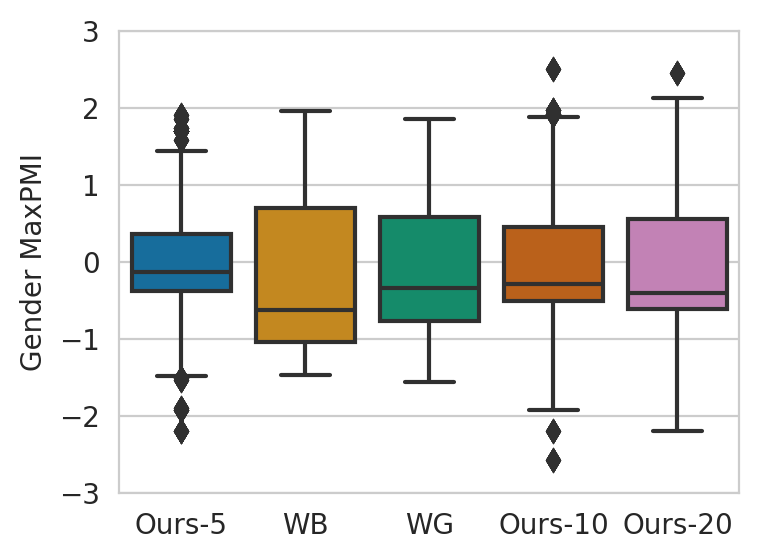

In [13]:
DATASET_ORDERING = ["Ours-5", "Ours-10", "Ours-20", "Winobias", "Winogender"]
RESULTS_GENDER_MAX_PER_SENT = compute_measure_per_sentence(PMI_PER_TEMPLATES, sentence_gender_max)
RESULTS_GENDER_MAX_PER_SENT["dataset_"] = RESULTS_GENDER_MAX_PER_SENT.dataset.apply(lambda x: "WB" if x == "Winobias" else ("WG" if x == "Winogender" else x))

plt.figure(figsize=(4, 3), dpi=200)
sns.boxplot(RESULTS_GENDER_MAX_PER_SENT, x="dataset_", y="value")
plt.ylim(-3, 3)
plt.ylabel("Gender MaxPMI")
plt.xlabel(None)
plt.show()

# Table results
RESULTS_GENDER_MAX_PER_SENT[["dataset", "value"]].groupby("dataset").describe().T[DATASET_ORDERING].style.format('{:.2f}')

In [14]:
# Number of templates per dataset
num_templates = RESULTS_GENDER_MAX_PER_SENT.groupby("dataset").count()[["value"]]
num_templates.rename({"value": "orig_num_templates"}, axis=1, inplace=True)
num_templates

,orig_num_templates
dataset,
Ours-10,61620
Ours-20,62907
Ours-5,57252
Winobias,20618
Winogender,3120


In [40]:
def filter_data_by_col_val(data:pd.DataFrame, col="value", thres=1):
    return data[(data[col] >= -thres) & (data[col] <= thres)]

def obtain_filtering_results(sentence_scores_per_sent, filtering_epsilons):
    filter_templates_results = {}
    for eps in filtering_epsilons:
        # number of examples after removing outliers outside [-1, 1]    
        df_eps = filter_data_by_col_val(sentence_scores_per_sent, thres=eps)

        # Obtain the number of remaining templates
        templ_diff = df_eps.groupby("dataset").count()["value"]
        # Obtain the difference in template counts by applying a specific filter.
        #templ_diff = df_eps.groupby("dataset").count()["value"] - num_templates["orig_num_templates"]
        filter_templates_results[round(eps, 2)] = templ_diff

    # How many templates we loose as we increase the filter
    filter_templates_results =  pd.DataFrame(filter_templates_results).T
    filter_templates_results = filter_templates_results.reset_index().rename({"index": "filter"}, axis=1)
    return filter_templates_results


FILTERING_EPSILONS = np.linspace(0.10, 2.5, 101)[::-1]
FILTERING_MAX_PER_SENT = obtain_filtering_results(RESULTS_GENDER_MAX_PER_SENT, FILTERING_EPSILONS)
FILTERING_MAX_PER_SENT.head()

dataset,filter,Ours-10,Ours-20,Ours-5,Winobias,Winogender
0,2.50,61594.0,62907.0,57252.0,20618.0,3120.0
1,2.48,61594.0,62907.0,57252.0,20618.0,3120.0
2,2.45,61594.0,62907.0,57252.0,20618.0,3120.0
3,2.43,61594.0,62894.0,57252.0,20618.0,3120.0
4,2.40,61594.0,62894.0,57252.0,20618.0,3120.0


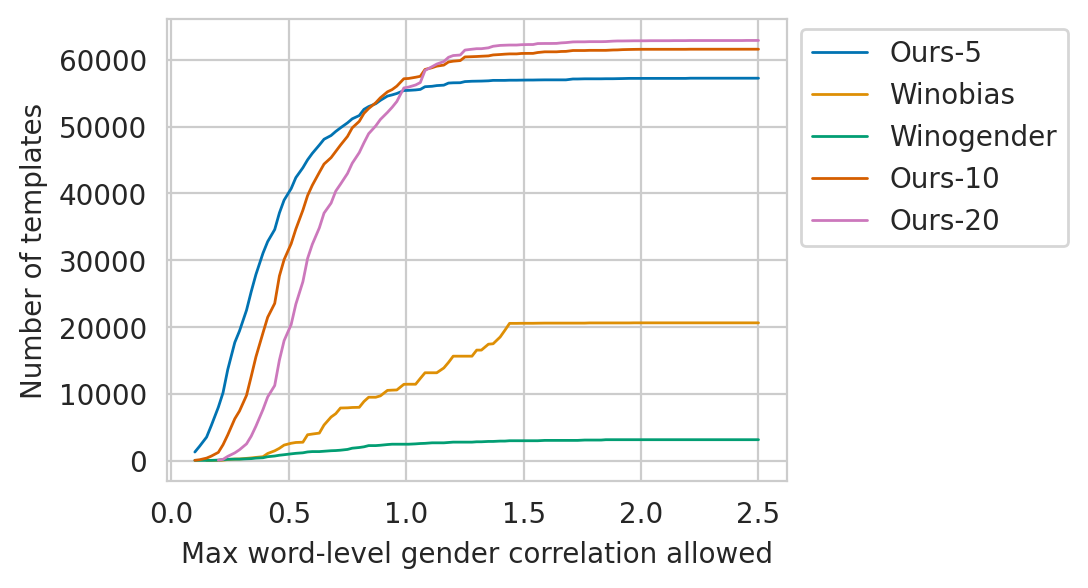

In [16]:
filter_templates_results = FILTERING_MAX_PER_SENT.copy()
plt.figure(figsize=(4,3), dpi=200)
for dataset in DATANAMES:
    sns.lineplot(filter_templates_results, x="filter", y=dataset, label=dataset, lw=1)

plt.xlabel("Max word-level gender correlation allowed")
plt.ylabel("Number of templates")
plt.legend( loc='upper left', bbox_to_anchor=(1, 1.01))

dataset,filter,Ours-10,Ours-20,Ours-5,Winobias,Winogender
0,2.50,61594.0,62907.0,57252.0,20618.0,3120.0
1,2.48,61594.0,62907.0,57252.0,20618.0,3120.0
2,2.45,61594.0,62907.0,57252.0,20618.0,3120.0
3,2.43,61594.0,62894.0,57252.0,20618.0,3120.0
4,2.40,61594.0,62894.0,57252.0,20618.0,3120.0
...,...,...,...,...,...,...
96,0.20,1222.0,52.0,7982.0,26.0,65.0
97,0.17,663.0,NaN,5239.0,13.0,26.0
98,0.15,364.0,NaN,3510.0,13.0,26.0
99,0.12,117.0,NaN,2132.0,NaN,26.0


To ensure compatibility with the gender bias computation we had to load every model dataframe. So we have num_models * original data. We can account for that in the following line:

In [17]:
_filter_templates_results = filter_templates_results.copy() 
_filter_templates_results[DATASET_ORDERING] = (_filter_templates_results[DATASET_ORDERING] / NUM_EVAL_MODELS).fillna(0).astype(int) #/ _filter_templates_results[DATASET_ORDERING].iloc[0]).round(2) 

print(
    (_filter_templates_results[["filter"] + DATASET_ORDERING])\
      .to_latex(
            caption=f".",
            label="tab:tradeoff__maxpmi__num_templates",
    )
 )

_filter_templates_results[["filter"] + DATASET_ORDERING]

\begin{table}
\caption{.}
\label{tab:tradeoff__maxpmi__num_templates}
\begin{tabular}{lrrrrrr}
\toprule
dataset & filter & Ours-5 & Ours-10 & Ours-20 & Winobias & Winogender \\
\midrule
0 & 2.500000 & 4404 & 4738 & 4839 & 1586 & 240 \\
1 & 2.480000 & 4404 & 4738 & 4839 & 1586 & 240 \\
2 & 2.450000 & 4404 & 4738 & 4839 & 1586 & 240 \\
3 & 2.430000 & 4404 & 4738 & 4838 & 1586 & 240 \\
4 & 2.400000 & 4404 & 4738 & 4838 & 1586 & 240 \\
5 & 2.380000 & 4404 & 4738 & 4838 & 1586 & 240 \\
6 & 2.360000 & 4404 & 4738 & 4838 & 1586 & 240 \\
7 & 2.330000 & 4404 & 4738 & 4838 & 1586 & 240 \\
8 & 2.310000 & 4404 & 4738 & 4838 & 1586 & 240 \\
9 & 2.280000 & 4404 & 4738 & 4838 & 1586 & 240 \\
10 & 2.260000 & 4404 & 4738 & 4838 & 1586 & 240 \\
11 & 2.240000 & 4404 & 4738 & 4838 & 1586 & 240 \\
12 & 2.210000 & 4404 & 4738 & 4838 & 1586 & 240 \\
13 & 2.190000 & 4402 & 4737 & 4837 & 1586 & 240 \\
14 & 2.160000 & 4402 & 4737 & 4837 & 1586 & 240 \\
15 & 2.140000 & 4402 & 4737 & 4837 & 1586 & 240 \\
16 & 2.1

dataset,filter,Ours-5,Ours-10,Ours-20,Winobias,Winogender
0,2.50,4404,4738,4839,1586,240
1,2.48,4404,4738,4839,1586,240
2,2.45,4404,4738,4839,1586,240
3,2.43,4404,4738,4838,1586,240
4,2.40,4404,4738,4838,1586,240
...,...,...,...,...,...,...
96,0.20,614,94,4,2,5
97,0.17,403,51,0,1,2
98,0.15,270,28,0,1,2
99,0.12,164,9,0,0,2


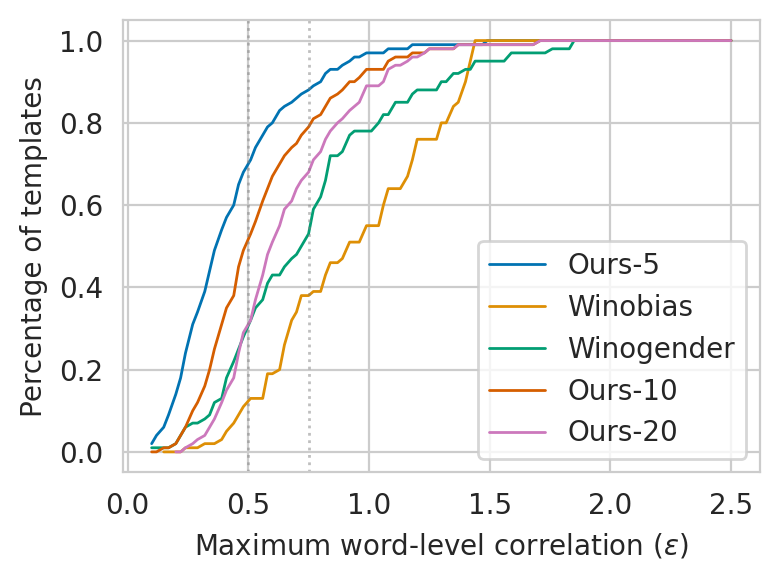

In [18]:
_filter_templates_results = filter_templates_results.copy() 
_filter_templates_results[DATASET_ORDERING] = (_filter_templates_results[DATASET_ORDERING] / _filter_templates_results[DATASET_ORDERING].iloc[0]).round(2) 


plt.figure(figsize=(4,3), dpi=200)
for dataset in DATANAMES:
    sns.lineplot(_filter_templates_results, x="filter", y=dataset, label=dataset, lw=1)

plt.xlabel("Maximum word-level correlation ($\epsilon$)")
plt.ylabel("Percentage of templates")
#plt.legend( loc='upper left', bbox_to_anchor=(0, -0.2), ncols=3)
plt.axvline(0.5, ls=":", color="gray", alpha=0.5, lw=1)
plt.axvline(0.75, ls=":", color="gray", alpha=0.5, lw=1)
plt.tight_layout()
plt.show()

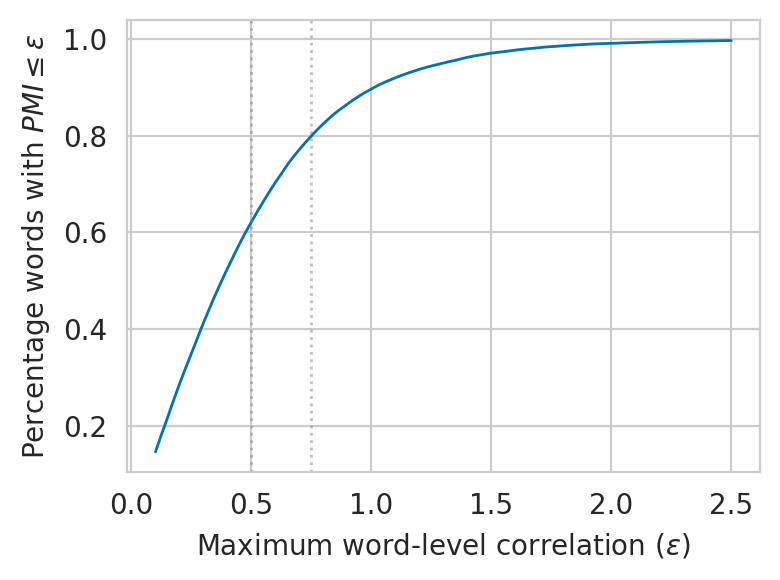

In [19]:
# TODO -- can also compute the pct of attribute words that remain after cropping up eps
num_words_w_filter_results = {eps: (PMI_DIFF["pmi_diff"].apply(np.abs) <= eps).sum() / len(PMI_DIFF) for eps in FILTERING_EPSILONS}
num_words_w_filter_results = pd.DataFrame(num_words_w_filter_results.items(), columns=["filter", "pct_words"])

plt.figure(figsize=(4,3), dpi=200)
sns.lineplot(num_words_w_filter_results, x="filter", y="pct_words", lw=1)

plt.xlabel("Maximum word-level correlation ($\epsilon$)")
plt.ylabel("Percentage words with $PMI \leq \epsilon$")
#plt.legend( loc='upper left', bbox_to_anchor=(0, -0.2), ncols=3)
plt.axvline(0.5, ls=":", color="gray", alpha=0.5, lw=1)
plt.axvline(0.75, ls=":", color="gray", alpha=0.5, lw=1)
plt.tight_layout()
plt.show()

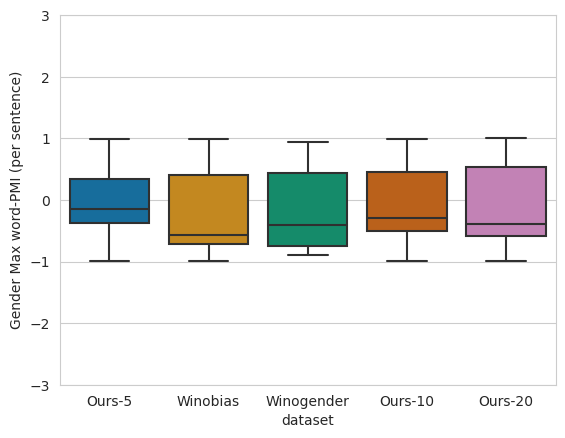

In [20]:
RESULTS_FILTER_BY_1 = filter_data_by_col_val(RESULTS_GENDER_MAX_PER_SENT, thres=1)
sns.boxplot(RESULTS_FILTER_BY_1, x="dataset", y="value")
plt.ylim(-3, 3)
plt.ylabel("Gender Max word-PMI (per sentence)")
plt.show()

RESULTS_FILTER_BY_1[["dataset", "value"]].groupby("dataset").describe().T[DATASET_ORDERING].style.format('{:.2f}')

,dataset,template_idx,value,is_invalid,dataset_
0,Ours-5,0,0.357130,False,Ours-5
1,Ours-5,1,0.268167,False,Ours-5
2,Ours-5,2,-0.487007,False,Ours-5
3,Ours-5,3,0.819088,False,Ours-5
4,Ours-5,4,-0.358365,False,Ours-5
...,...,...,...,...,...
205524,Ours-20,62901,0.450240,False,Ours-20
205525,Ours-20,62902,-0.300411,False,Ours-20
205526,Ours-20,62903,-0.751960,False,Ours-20
205527,Ours-20,62904,-0.541400,False,Ours-20


In [21]:
WORD2PMI["secretary"], WORD2PMI["physician"], WORD2PMI["patient"]

(0.09741073662610233, -0.13730730584517303, 0.18206902072953213)

In [22]:
def filter_dataframe(original_file: pd.DataFrame, dataset: str, gender_max: pd.DataFrame, col="value", eps=1):
    original_file = original_file.copy()
    
    # make sure the gender_max is specific to our original dataset (shouldn't have any ordering other than the index)
    max_df = gender_max[gender_max["dataset"] == dataset]
    assert (np.array(original_file.index) == max_df["template_idx"].values).all(), "Index mismatch"
    # keep templates whose col value is within [-eps, eps]
    filtered_df = filter_data_by_col_val(max_df, col=col, thres=eps)
    
    # add information about the value and whether we were able to obtain any PMI value for that sentence
    for c in (col, "is_invalid"):
        original_file[c] = max_df[c].values
    #print(max_df["value"].head())
    #print("=====")
    #print(original_file["value"].head())
    # Mark every example to be dropped by default
    original_file["is_dropped"] = True
    # Collect a mask w/ the indication of whether that template is to be kept or not
    keep_mask = original_file.index.isin(filtered_df["template_idx"])
    original_file.loc[keep_mask, "is_dropped"] = False    
    return original_file

In [23]:
DROPPED_EXAMPLES_EPS1 = {
    k: filter_dataframe(f, k, RESULTS_GENDER_MAX_PER_SENT, eps=1)
    for k, f in DATASET_2_FILES.items()
}

for name, df in DROPPED_EXAMPLES_EPS1.items():
    print(df["is_dropped"].value_counts() / NUM_EVAL_MODELS)
    print()

is_dropped
False    4263.0
True      142.0
Name: count, dtype: float64

is_dropped
False    879.0
True     707.0
Name: count, dtype: float64

is_dropped
False    188.0
True      52.0
Name: count, dtype: float64

is_dropped
False    4400.0
True      340.0
Name: count, dtype: float64

is_dropped
False    4299.0
True      540.0
Name: count, dtype: float64



# Bias metric


### 1. Filter examples

In [24]:
FILTER_GENDER_MAX_PMI = [0.65, 0.8, 1]

# To compute the values that we need for the paper, we will consider the thresholds 0.65 and 0.80 and 1

BIAS_FILES_BEF_DROPPED = {
    filt: { k: filter_dataframe(f, k, RESULTS_GENDER_MAX_PER_SENT, eps=filt) for k, f in DATASET_2_FILES.items() }
    for filt in FILTER_GENDER_MAX_PMI
}

BIAS_FILES_AFT_DROPPED = {
    filt: {k: df[~df["is_dropped"]] for k, df in BIAS_FILES_BEF_DROPPED[filt].items()}
    for filt in FILTER_GENDER_MAX_PMI
}

for filt in FILTER_GENDER_MAX_PMI:
    for k in BIAS_FILES_BEF_DROPPED[filt].keys():
        print(filt, k, "\t", len(BIAS_FILES_BEF_DROPPED[filt][k]) / NUM_EVAL_MODELS, len(BIAS_FILES_AFT_DROPPED[filt][k])/NUM_EVAL_MODELS)

0.65 Ours-5 	 4405.0 3701.0
0.65 Winobias 	 1586.0 409.0
0.65 Winogender 	 240.0 107.0
0.65 Ours-10 	 4740.0 3412.0
0.65 Ours-20 	 4839.0 2845.0
0.8 Ours-5 	 4405.0 3978.0
0.8 Winobias 	 1586.0 675.0
0.8 Winogender 	 240.0 150.0
0.8 Ours-10 	 4740.0 3920.0
0.8 Ours-20 	 4839.0 3569.0
1 Ours-5 	 4405.0 4263.0
1 Winobias 	 1586.0 879.0
1 Winogender 	 240.0 188.0
1 Ours-10 	 4740.0 4400.0
1 Ours-20 	 4839.0 4299.0


In [25]:
DEFAULT_PALETTE = sns.color_palette("colorblind", n_colors=len(DATASET_NAMES))
# Define dataset colors
DATASET_COLORS = {name: color for name, color in zip(DATASET_NAMES, DEFAULT_PALETTE)}

## Pct of "neutral" for fixed threshold

In this section, we compute the number of examples that lie within the interval $[-\epsilon, \epsilon]$. To this end, we will have to compute the _skew_. We'll say the model skews male if the log ratio is in the interval $(-\infty, \epsilon]$. and skews female if is in the other extreme. 




In [26]:
FIXED_FAIRNESS_THRESHOLD = 0.5
FAIRNESS_COL = "FM_logprob"

In [27]:
import glob, operator


def is_neutral(df, col=FAIRNESS_COL, threshold: float=FIXED_FAIRNESS_THRESHOLD):
    assert 0 <= threshold <= 1
    assert col in df.columns
    return (df[col] >= -threshold) & (df[col] <= threshold)


def get_skew(df, col=FAIRNESS_COL, threshold: float=FIXED_FAIRNESS_THRESHOLD):
    assert 0 <= threshold <= 1
    assert col in df.columns

    df = df.copy()
    df["skew"] = ["neutral"] * len(df)
    df.loc[df[col] < -threshold, "skew"] = "male"
    df.loc[df[col] >  threshold, "skew"] = "female"
    return df["skew"]


def get_bins(val, max_val=100, edges=(15, 10, 5, 2.5, 1, FIXED_FAIRNESS_THRESHOLD)):
    __base_interval = pd.Interval(-edges[-1], edges[-1], closed="both")
    sign = np.sign(val)
    threshold = edges[-1]

    if sign == 0 or  -threshold <= val <= threshold:
        return __base_interval

    op = operator.gt if sign > 0 else operator.le
    edges = [sign * max_val] + [e * sign for e in edges]


    for i in range(1, len(edges)):
        if op(val, edges[i]):
            e1, e2 = edges[i-1], edges[i]
            bins = (e1, e2) if sign < 0 else (e2, e1)
            return pd.Interval(*bins, closed="neither" if sign < 0 and bins[-1] == -threshold else "right")

In [28]:
def compute_skews_(data_files: dict, fairness_col, fairness_threshold):
    # Note: This cell is going to add columns to the original dataframes in DATASET_2_FILES
    for name, df in data_files.items():
        get_fair_bins = lambda x: get_bins(val=x, max_val=100, edges=(15, 10, 5, 2.5, 1, fairness_threshold))
        df[f"{fairness_col}_bins"] = df[fairness_col].apply(get_fair_bins)

        df["is_neutral"] = is_neutral(df, fairness_col, fairness_threshold)
        # Obtain a discrete measure of what gender does the model fairness_col, skews
        # note: it assumes that positive values of fairness col will skew female
        # completions; and negative values skew male completions...
        df["skew"] = get_skew(df, fairness_col, fairness_threshold)
        
    return data_files

In [29]:
BIAS_FILES_BEF_DROPPED = {
    filt: compute_skews_(bias_files, FAIRNESS_COL, FIXED_FAIRNESS_THRESHOLD) for filt, bias_files in BIAS_FILES_BEF_DROPPED.items()
}

BIAS_FILES_AFT_DROPPED = {
    filt: compute_skews_(bias_files, FAIRNESS_COL, FIXED_FAIRNESS_THRESHOLD) for filt, bias_files in BIAS_FILES_AFT_DROPPED.items()
}

/tmp/ipykernel_4130635/260488455.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f"{fairness_col}_bins"] = df[fairness_col].apply(get_fair_bins)
/tmp/ipykernel_4130635/260488455.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["is_neutral"] = is_neutral(df, fairness_col, fairness_threshold)
/tmp/ipykernel_4130635/260488455.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

/tmp/ipykernel_4130635/260488455.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f"{fairness_col}_bins"] = df[fairness_col].apply(get_fair_bins)
/tmp/ipykernel_4130635/260488455.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["is_neutral"] = is_neutral(df, fairness_col, fairness_threshold)
/tmp/ipykernel_4130635/260488455.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

In [30]:
df.columns

Index(['target_word', 'sentence', 'has_placeholder', 'template',
       'modifications', 'likely_under', 'is_natural', 'has_word', 'is_revised',
       'M_num_tokens', 'M_logprob', 'M_template', 'F_num_tokens', 'F_logprob',
       'F_template', 'FM_logprob', 'model', 'dataset', 'is_deduped', '__model',
       'model_basename', '__model_size', 'model_step', 'model_intervention',
       'value', 'is_invalid', 'is_dropped'],
      dtype='object')

In [31]:
df.model.unique()

array(['pythia-6.9b (D)', 'pythia-intervention-6.9b (D)'], dtype=object)

In [32]:
DATA = BIAS_FILES_BEF_DROPPED[1]

# print(len(model_names) / NUM_EVAL_MODELS)
__scatter_results = defaultdict(list)

for dataset in DATANAMES:
    df = DATA[dataset].copy()
    __pct_examples = df.groupby(["__model", "skew"]).count()["template"]
    model_names = sorted(set(__pct_examples.index.get_level_values(0)))
    
    for model in model_names:
        _model_res = __pct_examples[model]

        total = _model_res.sum()
        __scatter_results["model"].append(model)
        __scatter_results["dataset"].append(dataset)
        __scatter_results["total"].append(total)
        __scatter_results["% neutral"].append(_model_res["neutral"] / total)
        __scatter_results["% female"].append(_model_res["female"] / total)
        __scatter_results["% male"].append(_model_res["male"] / total)

__scatter_results = pd.DataFrame(__scatter_results)
__scatter_results["step"] = __scatter_results["model"].apply(lambda s: int(s.rpartition("__step")[-1]))
__scatter_results["intervention"] = __scatter_results["model"].apply(lambda s: "intervention" if "intervention" in s else "deduped")
assert __scatter_results["total"].nunique()==len(DATANAMES)

results = []
for ix, item in __scatter_results.iterrows():
    item = item.to_dict()
    results.append(item)
    if item["step"] == 133000:
        dup = {k: v for k,v in item.items()}
        dup["intervention"] = "intervention"
        results.append(dup)
    

__scatter_results = pd.DataFrame(results)

(0.0, 150000.0)

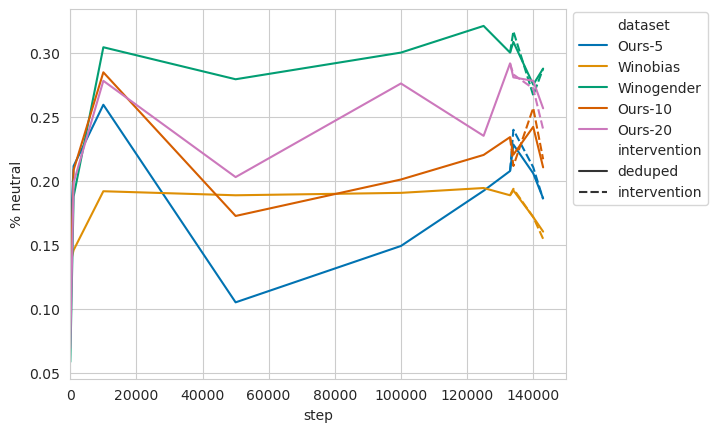

In [33]:
sns.lineplot(__scatter_results, x="step", y="% neutral", hue="dataset", style="intervention")
plt.legend( loc='upper left', bbox_to_anchor=(1, 1.01))
plt.xlim(0, 150_000)
#plt.ylim(0.25, 0.8)

(0.0, 150000.0)

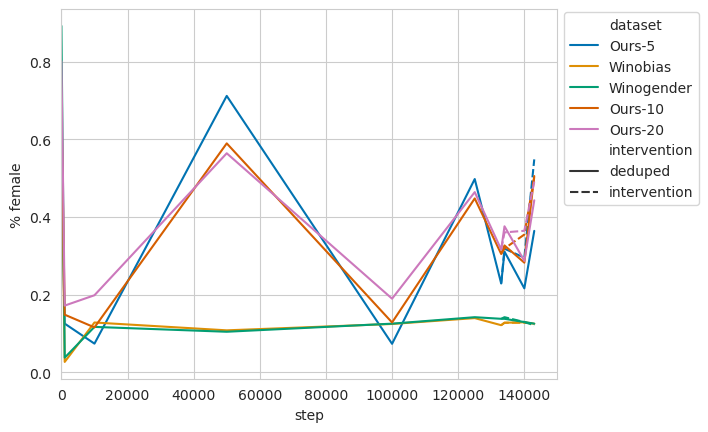

In [34]:
sns.lineplot(__scatter_results, x="step", y="% female", hue="dataset", style="intervention")
plt.legend( loc='upper left', bbox_to_anchor=(1, 1.01))
plt.xlim(0, 150_000)
#plt.ylim(0.25, 0.8)

(0.0, 150000.0)

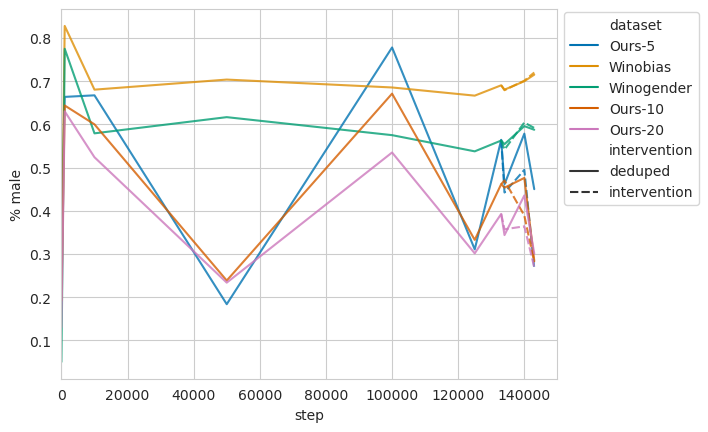

In [35]:
sns.lineplot(__scatter_results, x="step", y="% male", hue="dataset", style="intervention", alpha=0.8)
plt.legend( loc='upper left', bbox_to_anchor=(1, 1.01))
plt.xlim(0, 150_000)
#plt.ylim(0.25, 0.8)

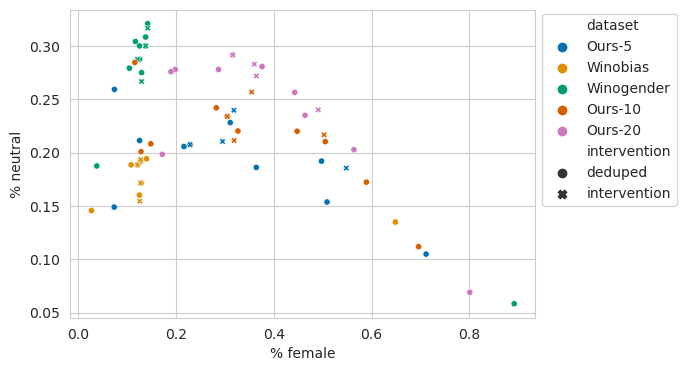

In [36]:
plt.figure(figsize=(6,4))

sns.scatterplot(__scatter_results, x="% female", y="% neutral", hue="dataset", style="intervention", s=20)
plt.legend( loc='upper left', bbox_to_anchor=(1, 1.01))

In [37]:
# add boundaries
plt.figure(figsize=(6,4), dpi=200)

neutral_pcts = np.linspace(0, 0.5, 21)
sns.lineplot(x=female_pcts, y=neutral_pcts, ls='--', c="gray")
# add margin
female_pcts = (1 - neutral_pcts)/2
sns.lineplot(x=female_pcts, y=neutral_pcts, ls='--', c="gray")

margins_20_pct_lowerbound = female_pcts - 0.2
margins_20_pct_upperbound = female_pcts + 0.2
plt.fill_betweenx(neutral_pcts, margins_20_pct_upperbound, margins_20_pct_lowerbound, color="lightgray", alpha=0.25)

margins_10_pct_lowerbound = female_pcts - 0.1
margins_10_pct_upperbound = female_pcts + 0.1
plt.fill_betweenx(neutral_pcts, margins_10_pct_upperbound, margins_10_pct_lowerbound, color="lightgray", alpha=0.35)


sns.scatterplot(__scatter_results, x="% female", y="% neutral", hue="dataset", style="Intervention", alpha=0.8, edgecolor="black")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1.01))
plt.xlabel("% predicted female")
plt.ylabel("% predicted neutral")
plt.tight_layout()

NameError: name 'female_pcts' is not defined

<Figure size 1200x800 with 0 Axes>

In [ ]:
# add boundaries
plt.figure(figsize=(6,4), dpi=200)

neutral_pcts = np.linspace(0, 0.5, 21)
sns.lineplot(x=female_pcts, y=neutral_pcts, ls='--', c="gray")
# add margin
female_pcts = (1 - neutral_pcts)/2
sns.lineplot(x=female_pcts, y=neutral_pcts, ls='--', c="gray")

margins_20_pct_lowerbound = female_pcts - 0.2
margins_20_pct_upperbound = female_pcts + 0.2
plt.fill_betweenx(neutral_pcts, margins_20_pct_upperbound, margins_20_pct_lowerbound, color="lightgray", alpha=0.25)

margins_10_pct_lowerbound = female_pcts - 0.1
margins_10_pct_upperbound = female_pcts + 0.1
plt.fill_betweenx(neutral_pcts, margins_10_pct_upperbound, margins_10_pct_lowerbound, color="lightgray", alpha=0.35)


ax = sns.scatterplot(__scatter_results, x="% female", y="% neutral", hue="dataset", style="model family", alpha=0.8, edgecolor="black")
# legend.texts[1].set_text('') 
plt.legend(loc='upper left', bbox_to_anchor=(1, 1.01))
plt.xlabel("% predicted female")
plt.ylabel("% predicted neutral")
plt.tight_layout()

In [ ]:
legend.texts[0]

In [ ]:
# add boundaries
plt.figure(figsize=(6,4), dpi=200)

neutral_pcts = np.linspace(0, 0.5, 21)
sns.lineplot(x=female_pcts, y=neutral_pcts, ls='--', c="gray")
# add margin
female_pcts = (1 - neutral_pcts)/2
sns.lineplot(x=female_pcts, y=neutral_pcts, ls='--', c="gray")

margins_20_pct_lowerbound = female_pcts - 0.2
margins_20_pct_upperbound = female_pcts + 0.2
plt.fill_betweenx(neutral_pcts, margins_20_pct_upperbound, margins_20_pct_lowerbound, color="lightgray", alpha=0.25)

margins_10_pct_lowerbound = female_pcts - 0.1
margins_10_pct_upperbound = female_pcts + 0.1
plt.fill_betweenx(neutral_pcts, margins_10_pct_upperbound, margins_10_pct_lowerbound, color="lightgray", alpha=0.35)


ax = sns.scatterplot(__scatter_results, x="% female", y="% neutral", hue="dataset", style="training", alpha=0.8, edgecolor="black")
# ax.get_legend().remove()
plt.xlabel("% predicted female")
plt.ylabel("% predicted neutral")
plt.tight_layout()
plt.show()

In [ ]:
# add boundaries
plt.figure(figsize=(6,4), dpi=200)

neutral_pcts = np.linspace(0, 0.5, 21)
sns.lineplot(x=female_pcts, y=neutral_pcts, ls='--', c="gray")
# add margin
female_pcts = (1 - neutral_pcts)/2
sns.lineplot(x=female_pcts, y=neutral_pcts, ls='--', c="gray")

margins_20_pct_lowerbound = female_pcts - 0.2
margins_20_pct_upperbound = female_pcts + 0.2
plt.fill_betweenx(neutral_pcts, margins_20_pct_upperbound, margins_20_pct_lowerbound, color="lightgray", alpha=0.25)

margins_10_pct_lowerbound = female_pcts - 0.1
margins_10_pct_upperbound = female_pcts + 0.1
plt.fill_betweenx(neutral_pcts, margins_10_pct_upperbound, margins_10_pct_lowerbound, color="lightgray", alpha=0.35)


ax = sns.scatterplot(__scatter_results, x="% female", y="% neutral", hue="dataset",alpha=0.8, edgecolor="black")
plt.legend( loc='upper left', bbox_to_anchor=(1, 1.01))
plt.xlabel("% predicted female")
plt.ylabel("% predicted neutral")
plt.tight_layout()

In [ ]:
DEFAULT_PALETTE

In [ ]:
__aft_dropping = BIAS_FILES_AFT_DROPPED[0.65].copy()

## Figure 1. Get examples

In [ ]:
import spacy
nlp = spacy.load("en_core_web_sm")



In [ ]:
doc = nlp("He takes time to his self-care routine!")
for token in doc:
    print(token.text, token.pos_, token.dep_)

In [ ]:
WORD2PMI["self"], WORD2PMI["care"]

In [ ]:
BIAS_FILES_AFT_DROPPED[0.65]

In [ ]:
dataset = 'Ours-5'
examples_fig1 = BIAS_FILES_AFT_DROPPED[0.65][dataset].copy()
mask = ( 
    (examples_fig1["value"].apply(np.abs) <= 0.2)
    & (~examples_fig1["is_neutral"])
)
examples_fig1[mask].groupby(["template", "skew"]).count()["sentence"].to_csv(f"./{dataset}_filtered_examples_model_biased.csv")
examples_fig1[mask].groupby(["template", "skew"]).count()["sentence"]

## Percentage of examples $\in [-\epsilon, \epsilon]$

Let us compute the percentage of examples in each dataset that is within the specified threshold. We'll first create a table, as it is easier to represent in a paper.

In [ ]:
def get_pct_neutral_per_dataset(data_2_files: dict, use_filter_version=False):
    pct_neutral_per_dataset = {}

    for name, df in data_2_files.items():
        if use_filter_version and "is_natural" in df.columns:
            print("Filtering dataset", name, len(df))
            df = df[df["is_natural"]]
            print("Remaining", len(df))
        # Count number of neutral examples by model
        count_neutral = df.loc[df["is_neutral"]].groupby(["model"]).count()
        # Count total number of examples by model (should be the same for all of the models)
        count_total_sentences = df.groupby(["model"]).count()
        # The percentage is the number of neutral divided by the toal number of sentences
        pct_neutral_per_dataset[name] = (count_neutral / count_total_sentences)[["template"]]

    pct_neutral_per_dataset = pd.concat(pct_neutral_per_dataset).reset_index()
    pct_neutral_per_dataset.columns = ["dataset", "model_name", "is_neutral_pct"]
    
    return pct_neutral_per_dataset

### Compute pct neutral

Note by default the filtering (whether to use is_natural column) to filter the results is already being applied at the top of the document. Consider editing that cell to be able to perform filtering or unfiltering.

In [ ]:
col_ordering = ['Model', 'Ours-5', 'Ours-10', 'Ours-20', 'Winobias', 'Winogender']

def get_tables_pct(data2files,  use_filter_version=False, col_ordering=col_ordering):
    pct_neutral_per_dataset = get_pct_neutral_per_dataset(data2files, use_filter_version=use_filter_version)
    # print(len(pct_neutral_per_dataset))
    pct_neutral_table = pd.pivot(pct_neutral_per_dataset, values=["is_neutral_pct"], index="model_name", columns=["dataset"])

    pct_neutral_table_flat_header = pct_neutral_table.droplevel(None, axis=1).rename_axis(None, axis=1).reset_index() 
    #pct_neutral_table_flat_header.to_csv("./tables/bias_metric__pct_in_interval_0.5__by_model_and_dataset_with_likely_filter.csv")

    # Make model name canonical
    pct_neutral_table_flat_header["Model"] = \
        pct_neutral_table_flat_header.model_name.apply(canonic_model_name)

    pct_neutral_table_flat_header["_model"] = \
        pct_neutral_table_flat_header.Model.apply(lambda x: x.rpartition("-")[0])
    pct_neutral_table_flat_header["_size"] = \
        pct_neutral_table_flat_header.model_name.apply(get_model_size)

    pct_neutral_table_flat_header = pct_neutral_table_flat_header.sort_values(["_model", "_size"])

    # Format as pct but without % symbol
    pct_neutral_table_flat_header[col_ordering[1:]] = pct_neutral_table_flat_header[col_ordering[1:]] * 100


    #print(
    #    (pct_neutral_table_flat_header[col_ordering]).set_index("Model").to_latex(
    #        caption=f"Percentage of the examples per dataset and model with log-probability ratio in $[-{FIXED_FAIRNESS_THRESHOLD}, {FIXED_FAIRNESS_THRESHOLD}]$.",
    #        label="tab:bias-metric--pct-neutral-05--all-model-and-data-w-likely-filter",
    #        # Add pct formatter to all columns except model name
    #        formatters={c: '{:,.2f}'.format for c in col_ordering[1:]},
    #    )
    #)

    return pct_neutral_table_flat_header[col_ordering].set_index("Model")

In [ ]:
# tables before dropped should all have the same exact result (since the filtering was not applied)
# serves as a (weak) sanity check that the code is alright...
TABLES_BEF_DROPPED = {filt: get_tables_pct(bias_files, False) for filt, bias_files in BIAS_FILES_BEF_DROPPED.items()}

# 
TABLES_AFT_DROPPED = {filt: get_tables_pct(bias_files, False) for filt, bias_files in BIAS_FILES_AFT_DROPPED.items()}

In [ ]:
TABLES_BEF_DROPPED[0.65].round(2)

In [ ]:
TABLES_AFT_DROPPED[0.65] - TABLES_BEF_DROPPED[0.65]

In [ ]:
TABLES_AFT_DROPPED[0.80] - TABLES_BEF_DROPPED[0.65]

In [ ]:
TABLES_AFT_DROPPED[1] - TABLES_BEF_DROPPED[0.65]

In [ ]:
TABLES_AFT_DROPPED.keys()